# Example First Deployment of a Model on Seldon

This demo will show you how to describe runtime inference graphs to deploy on seldon-core. We will take advantage of pre-wrapped dummy models that are ready to be managed by seldon-core. The [next notebook](https://github.com/SeldonIO/seldon-core-launcher/blob/master/seldon-core/getting_started/wrap-model/wrap_model.ipynb) will show you how to wrap your own runtime models for seldon.

## Requirements

 * If you are viewing this on the web then to run this notebook install jupyter and follow the steps below and click on deploy.ipynb when the jupyter page is shown:
 ```
 git clone https://github.com/SeldonIO/seldon-core-launcher.git
 cd seldon-core-launcher/seldon-core/getting_started/deployment
 jupyter notebook
 ```


 * You have a running cluster installed via the Google Marketplace with all the defaults including:
    * NodePort for the Seldon API OAuth Gateway. This gateway is used to connect your business apps to your running models via REST and gRPC.
    * The cluster is running in the default namespace
 * You have kubectl installed and authenticated with the cluster
 
 You will need to install some software for this demo:
 
 
 * Install the [requests library](http://docs.python-requests.org/en/master/) to allow you to make REST calls to the Seldon API gateway.
 * Install [python grpc tools](https://grpc.io/docs/quickstart/python.html) to allow you to make gRPC calls to the Seldon API gateway.
 * Install [graphviz](https://pypi.org/project/graphviz/) a package to display graphs.


## Set up REST and gRPC methods

**Ensure you port forward the seldon api-server REST and GRPC ports**, do this in separate terminals outside the notebook:

REST:
```
kubectl port-forward $(kubectl get pods -l app=seldon-apiserver-container-app -o jsonpath='{.items[0].metadata.name}') 8002:8080
```

GRPC:
```
kubectl port-forward $(kubectl get pods -l app=seldon-apiserver-container-app -o jsonpath='{.items[0].metadata.name}') 8003:5000
```

In [1]:
import requests
from requests.auth import HTTPBasicAuth
from proto import prediction_pb2
from proto import prediction_pb2_grpc
import grpc
try:
    from commands import getoutput # python 2
except ImportError:
    from subprocess import getoutput # python 3

API_HTTP="localhost:8002"
API_GRPC="localhost:8003"

def get_token():
    payload = {'grant_type': 'client_credentials'}
    response = requests.post(
                "http://"+API_HTTP+"/oauth/token",
                auth=HTTPBasicAuth('oauth-key', 'oauth-secret'),
                data=payload)
    print(response.text)
    token =  response.json()["access_token"]
    return token

def rest_request():
    token = get_token()
    headers = {'Authorization': 'Bearer '+token}
    payload = {"data":{"names":["a","b"],"tensor":{"shape":[2,2],"values":[0,0,1,1]}}}
    response = requests.post(
                "http://"+API_HTTP+"/api/v0.1/predictions",
                headers=headers,
                json=payload)
    print(response.text)
    
def grpc_request():
    token = get_token()
    datadef = prediction_pb2.DefaultData(
            names = ["a","b"],
            tensor = prediction_pb2.Tensor(
                shape = [3,2],
                values = [1.0,1.0,2.0,3.0,4.0,5.0]
                )
            )
    request = prediction_pb2.SeldonMessage(data = datadef)
    channel = grpc.insecure_channel(API_GRPC)
    stub = prediction_pb2_grpc.SeldonStub(channel)
    metadata = [('oauth_token', token)]
    response = stub.Predict(request=request,metadata=metadata)
    print(response)


## An Example Model
A simple example is shown below we use a single prepacked model for illustration. The spec contains a set of predictors each of which contains a ***componentSpecs*** which is a list of Kubernetes [PodTemplateSpec](https://kubernetes.io/docs/api-reference/v1.9/#podtemplatespec-v1-core) alongside a ***graph*** which describes how components fit together.

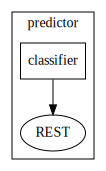

In [2]:
from visualizer import get_graph
get_graph("model.json")

The simple graph we will deploy has a single model "classifier" which is exposed via REST. The actual JSON for this representation is shown below:

In [3]:
!pygmentize ./model.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "seldon-deployment-example"
    },
    "spec": {
        "name": "test-deployment",
        "oauth_key": "oauth-key",
        "oauth_secret": "oauth-secret",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "seldonio/mock_classifier:1.0",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "classifier",
                                "resources": {
                                    "requests": {
                                        "memory": "1Mi"
                                    }
                                }
                            }
                        ],
        

Note your PodTemplateSpec inside componentSpecs has in this case kubernetes resource requests for 1 Mb of memory. You can also add volumes, and other requirements for your model to run successfully.

## Create Seldon Deployment

Deploy the runtime graph to kubernetes.

In [4]:
!kubectl apply -f ./model.json

seldondeployment "seldon-deployment-example" created


In [5]:
!kubectl get seldondeployments

NAME                        AGE
seldon-deployment-example   26s


Get the status of the SeldonDeployment. **When ready the replicasAvailable should be 1 for all components**.

In [6]:
!kubectl get seldondeployments seldon-deployment-example -o jsonpath='{.status}'

map[predictorStatus:[map[name:test-deployment-example-model-svc-orch replicas:1 replicasAvailable:1] map[replicas:1 replicasAvailable:1 name:test-deployment-example-model-classifier-0]]]

## Get predictions

#### REST Request
We will get an OAuth token using the key and secret we specified in the graph above and then call the REST endpoint of the API gateway with some random data.

In [7]:
rest_request()

{"access_token":"93f81a9e-4658-4e34-8f0a-cf232c125a20","token_type":"bearer","expires_in":43199,"scope":"read write"}
{
  "meta": {
    "puid": "f0oa4b21qvp4rhv69u7lekhj97",
    "tags": {
    },
    "routing": {
    }
  },
  "data": {
    "names": ["proba"],
    "tensor": {
      "shape": [2, 1],
      "values": [0.05133579311531625, 0.12823373759251927]
    }
  }
}


#### gRPC Request
We will an OAuth token using the key and secret we specified in the graph above and then call the gRPC endpoint of the API gateway with some random data.

In [8]:
grpc_request()

{"access_token":"93f81a9e-4658-4e34-8f0a-cf232c125a20","token_type":"bearer","expires_in":43198,"scope":"read write"}
meta {
  puid: "f7poerkdh55b46lqvo1devc87g"
}
data {
  names: "proba"
  tensor {
    shape: 3
    shape: 1
    values: 0.12823373759251927
    values: 0.39731466202150834
    values: 0.8296760813561542
  }
}



## Update deployment to AB test

We will change the deployment to add an AB test deployment. This illustrates:

 * Updating a deployment with no downtime.
 * Creating a more complex runtime graph.
 

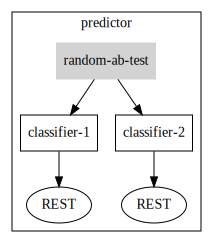

In [9]:
get_graph("random_ab_test.json")

As can be seen above we now have 2 models both serving REST requests and we have attached them behind a builtin component of Seldon which provides a random AB test router to split traffic between the two models.

In [10]:
!pygmentize ./random_ab_test.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
	"labels": {
	    "app": "seldon"
	},
	"name": "seldon-deployment-example"
    },
    "spec": {
	"name": "test-deployment-abtest",
	"oauth_key": "oauth-key",
	"oauth_secret": "oauth-secret",
	"predictors": [
	    {
		"componentSpecs": [{
		    "spec": {
			"containers": [
			    {
				"image": "seldonio/mock_classifier:1.0",
				"imagePullPolicy": "IfNotPresent",
				"name": "classifier-1",
				"resources": {
				    "requests": {
					"memory": "1Mi"
				    }
				}
			    }],
			"terminationGracePeriodSeconds": 20
		    }},
	        {
		    "metadata":{
			"labels":{
			    "version":"v2"
			}
		    },    
			"spec":{
			    "containers":[
			    {
				"image": "seldonio/mock_classifier:1.0",
				"imagePullPolicy": "IfNotPresent",
				"name": "classifier-2",
				"resources": {
				    "requests": {
					"memory": "1Mi"
				    }
				}
			    }
			],
			"terminationGracePeriodSe

In [11]:
!kubectl apply -f random_ab_test.json

seldondeployment "seldon-deployment-example" configured


Check the status of the deployments. Note: **Might need to run several times until replicasAvailable is 1 for both predictors**.

In [12]:
!kubectl get seldondeployments seldon-deployment-example -o jsonpath='{.status}'

map[predictorStatus:[map[replicas:1 replicasAvailable:1 name:test-deployment-abtest-classifier-svc-orch] map[name:test-deployment-abtest-classifier-classifier-1-0 replicas:1 replicasAvailable:1] map[name:test-deployment-abtest-classifier-classifier-2-1 replicas:1 replicasAvailable:1]]]

In [13]:
!kubectl get pods

NAME                                                              READY     STATUS    RESTARTS   AGE
seldon-core-1-redis-585647f8bf-qhk8n                              1/1       Running   0          2m
seldon-core-1-seldon-apiserver-b7d76b77d-vdlhw                    1/1       Running   0          2m
seldon-core-1-seldon-cluster-manager-76bd5f78c4-f5nt4             1/1       Running   0          2m
test-deployment-abtest-classifier-classifier-1-0-7dc9f857cc6s6j   1/1       Running   0          23s
test-deployment-abtest-classifier-classifier-2-1-756cccf45pvvzb   1/1       Running   0          23s
test-deployment-abtest-classifier-svc-orch-588dbc8457-w45h7       1/1       Running   0          23s
test-deployment-example-model-classifier-0-6bcb76d6bd-6kchl       1/1       Running   0          1m
test-deployment-example-model-svc-orch-586db57d89-fsnh8           1/1       Running   0          1m


#### REST Request
We should not have updated our deployment with the new model while the previous one will still be running. We can test again using the REST API. Note the "routing" meta data returned will show which route our request travelled, either "0" or "1" for the two runtime graphs we have created with separate models.

In [14]:
rest_request()

{"access_token":"93f81a9e-4658-4e34-8f0a-cf232c125a20","token_type":"bearer","expires_in":43158,"scope":"read write"}
{
  "meta": {
    "puid": "sipbt7bvr0nol7n344d400j4c6",
    "tags": {
    },
    "routing": {
      "random-ab-test": 1
    }
  },
  "data": {
    "names": ["proba"],
    "tensor": {
      "shape": [2, 1],
      "values": [0.05133579311531625, 0.12823373759251927]
    }
  }
}


#### gRPC request

In [15]:
grpc_request()

{"access_token":"93f81a9e-4658-4e34-8f0a-cf232c125a20","token_type":"bearer","expires_in":43155,"scope":"read write"}
meta {
  puid: "v4jvtpqbi016olhv6snjuqlspi"
}
data {
  names: "proba"
  tensor {
    shape: 3
    shape: 1
    values: 0.12823373759251927
    values: 0.39731466202150834
    values: 0.8296760813561542
  }
}



## Tear Down

In [16]:
!kubectl delete -f random_ab_test.json

seldondeployment "seldon-deployment-example" deleted


## Next Steps

Congratulations, you have deployed a model and interacted with it over REST and gRPC. You have then deployed an AB test between two models to update your runtime graph with no downtime.

For the next steps you will want to [wrap your own machine learning models to deploy onto seldon-core](https://github.com/SeldonIO/seldon-core-launcher/blob/master/seldon-core/getting_started/wrap-model/wrap_model.ipynb).